In [96]:
#imports
import os
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

In [42]:
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive')
print("Change successful.")

Mounted at /content/drive
Change successful.


In [67]:
data = pd.read_csv('brain_stroke.csv')
data.head(10)

gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1    Male  80.0             0              1          Yes        Private   
2  Female  49.0             0              0          Yes        Private   
3  Female  79.0             1              0          Yes  Self-employed   
4    Male  81.0             0              0          Yes        Private   
5    Male  74.0             1              1          Yes        Private   
6  Female  69.0             0              0           No        Private   
7  Female  78.0             0              0          Yes        Private   
8  Female  81.0             1              0          Yes        Private   
9  Female  61.0             0              1          Yes       Govt_job   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             105.92  32.5     never smoked       1  
2          Urban             171.23  34.4           smokes       1  
3          Rural             174.12  24.0     never smoked       1  
4          Urban             186.21  29.0  formerly smoked       1  
5          Rural              70.09  27.4     never smoked       1  
6          Urban              94.39  22.8     never smoked       1  
7          Urban              58.57  24.2          Unknown       1  
8          Rural              80.43  29.7     never smoked       1  
9          Rural             120.46  36.8           smokes       1

In [44]:
data.isna().sum()
#There are no null values

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [45]:
data.duplicated().sum()
#There are no duplicated rows

0

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [47]:
data.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  4981.000000   4981.000000    4981.000000        4981.000000   
mean     43.419859      0.096165       0.055210         105.943562   
std      22.662755      0.294848       0.228412          45.075373   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.230000   
50%      45.000000      0.000000       0.000000          91.850000   
75%      61.000000      0.000000       0.000000         113.860000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4981.000000  4981.000000  
mean     28.498173     0.049789  
std       6.790464     0.217531  
min      14.000000     0.000000  
25%      23.700000     0.000000  
50%      28.100000     0.000000  
75%      32.600000     0.000000  
max      48.900000     1.000000

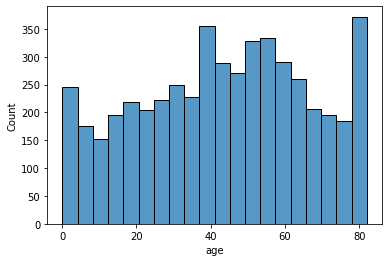

In [50]:
sns.histplot(data=data,x="age")
#The data is most likely sampled from a large population

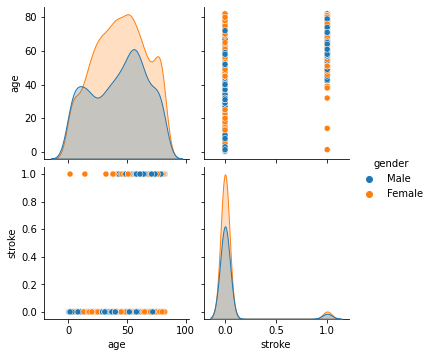

In [51]:
columns=data[["age","gender","stroke"]]
sns.pairplot(columns, hue="gender")
plt.show()
#We can drop the age column

In [68]:
data = data.drop(["age"],axis=1)
data.head(1)

gender  hypertension  heart_disease ever_married work_type Residence_type  \
0   Male             0              1          Yes   Private          Urban   

   avg_glucose_level   bmi   smoking_status  stroke  
0             228.69  36.6  formerly smoked       1

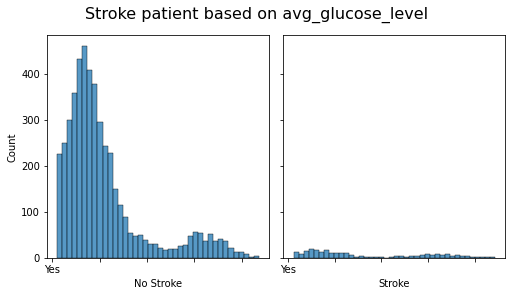

In [54]:
#Relationship between stroke and avg_gluose_level - lower glucose level => lower chance of stroke
create_comparison_graph('avg_glucose_level',40)

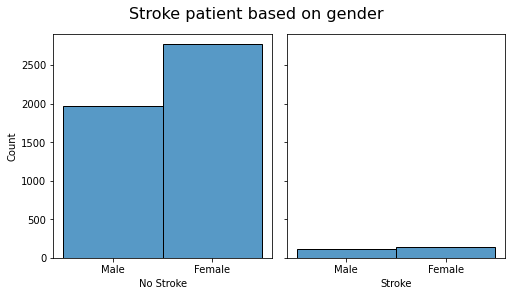

In [55]:
#Relationship between stroke and gender - N/A
create_comparison_graph('gender',ticks=False)

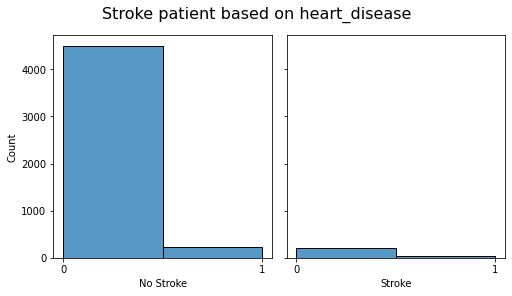

In [56]:
#Relationship between stroke and heart_disease - no heart disease => lower chance of getting stroke
#The conclusion is not confounding  ref: https://www.cdc.gov/stroke/risk_factors.htm#:~:text=Heart%20disease,rich%20blood%20to%20the%20brain.
create_comparison_graph('heart_disease',ticks=False)

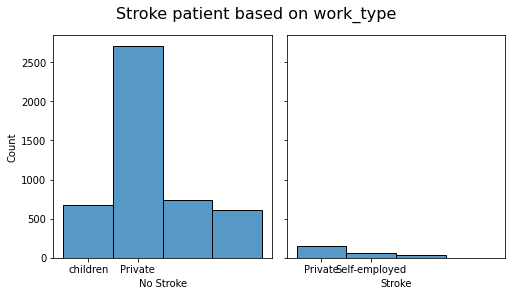

In [57]:
#Relationship between stroke and work_type - confounding?
create_comparison_graph('work_type',ticks=False)

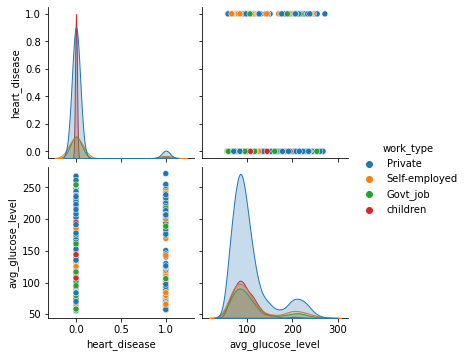

In [61]:
columns = data[["heart_disease","avg_glucose_level","work_type"]]
sns.pairplot(columns,hue="work_type")
plt.show()
#work_type is confounding

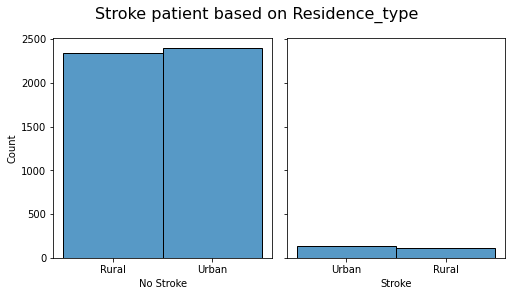

In [63]:
#Relationship between stroke and residence - N/A
create_comparison_graph('Residence_type',ticks=False)

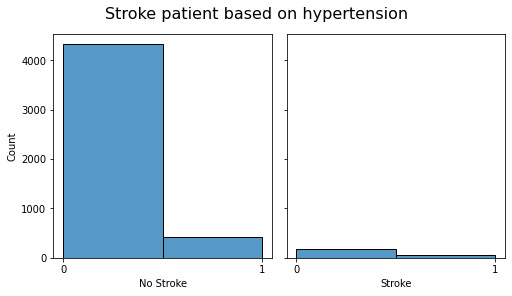

In [64]:
#Relationship between stroke and hypertension - lower hypertension => lower chance of stroke
create_comparison_graph('hypertension',ticks=False)

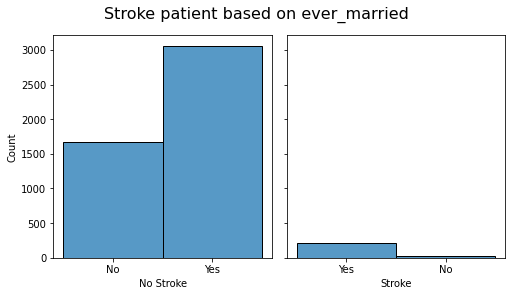

In [66]:
#Relationship between stroke and married status - yes
create_comparison_graph('ever_married',ticks=False)

## 2. Model Training

In [69]:
#drop gender, residence, work_type columns
data = data.drop(["gender","Residence_type","work_type"],axis=1)
data.head(1)

hypertension  heart_disease ever_married  avg_glucose_level   bmi  \
0             0              1          Yes             228.69  36.6   

    smoking_status  stroke  
0  formerly smoked       1

In [70]:
#convert non-object types to categorical values
encoder = LabelEncoder()
data['ever_married'] = encoder.fit_transform(data['ever_married'])
ever_married = {index : label for index, label in enumerate(encoder.classes_)}
data['smoking_status'] = encoder.fit_transform(data['smoking_status'])
smoking_status = {index : label for index, label in enumerate(encoder.classes_)}

In [80]:
x = data.drop('stroke',axis=1)
y = data['stroke']

In [81]:
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
X = scaler.fit_transform(x)

In [82]:
#train, test split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

### Decison Tree Classifier

In [83]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6)

In [84]:
y_predict = dt.predict(x_test)

In [87]:
print("Decision Tree Accuracy:")
print(accuracy_score(y_test,y_predict))

Decision Tree Accuracy:
0.9438314944834504


### SVM based classifier

In [91]:
svc = SVC(kernel='rbf', gamma=1, C=2)
svc.fit(x_train, y_train)

SVC(C=2, gamma=1)

In [92]:
y_predict = svc.predict(x_test)

In [93]:
print("SVC Accuracy:")
print(accuracy_score(y_test,y_predict))

SVC Accuracy:
0.9428284854563691
